**рекуррентная нейронная сеть LSTM**

Евгений Борисов <esborisov@sevsu.ru>


построим простую языковая модель и
обучим её предсказывать последнюю букву в слове


----

Sepp Hochreiter; Jürgen Schmidhuber (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780. PMID 9377276. doi:10.1162/neco.1997.9.8.1735.


Klaus Greff, Rupesh Kumar Srivastava, Jan Koutnı́k, Bas R. Steunebrink, Jürgen Schmidhuber
LSTM: A Search Space Odyssey     
http://arxiv.org/abs/1503.04069


Christopher Olah  LSTM – сети долгой краткосрочной памяти.     
https://habr.com/ru/companies/wunderfund/articles/331310/

    
Christopher Olah  Understanding LSTM Networks.   
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


Евгений Борисов  Рекуррентная сеть LSTM.    
http://mechanoid.su/neural-net-lstm.html 




---

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем тексты

In [2]:
# загружаем тексты
import gzip
import requests
from bs4 import BeautifulSoup

In [3]:
url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:1279540
---------------

Приступая к описанию недавних и столь странных событий, происшедших в нашем, доселе ничем не отличавшемся городе, я принужден, по неумению моему, начать несколько издалека, а именно некоторыми биографическими подробностями о талантливом и многочтимом Степане Трофимовиче Верховенском. Пусть эти подробности послужат лишь введением к предлагаемой хронике, 


----

In [4]:
data_size = 1024
offset = rng.randint( len(text) - data_size )
text_ = text[offset:offset+data_size]
print(text_)

, всё ему удавалось, он был в моде. В обществе в губернском если кто раз появился, то уж спрятаться никак нельзя. Николай Всеволодович стал по-прежнему исполнять все губернские порядки до утонченности. Веселым его не находили: "Человек претерпел, человек не то, что другие; есть о чем и задуматься". Даже гордость и та брезгливая неприступность, за которую так ненавидели его у нас четыре года назад, теперь уважались и нравились.
   Всех более торжествовала Варвара Петровна. Не могу сказать, очень ли тужила она о разрушившихся мечтах насчет Лизаветы Николаевны. Тут помогла, конечно, и фамильная гордость. Странно одно: Варвара Петровна в высшей степени вдруг уверовала, что Nicolas действительно "выбрал" у графа К., но, и что страннее всего, уверовала по слухам, пришедшим к ней, как и ко всем, по ветру; сама же боялась прямо спросить Николая Всеволодовича. Раза два-три, однако, не утерпела и весело исподтишка попрекнула его, что он с нею не так откровенен; Николай Всеволодович улыбался и пр

# собираем генератор дататасета

In [5]:
import torch
#import torch.nn.functional as F

In [6]:
from torch.utils.data import Dataset

In [7]:
class SeqDataset(Dataset):
    
    def __init__(self,text,contex_len,w_step=1):
        super().__init__()
        assert len(text)>1

        abc = sorted(set(text))
        self._vocabulary = { c:n for n,c in enumerate(abc) }
        self._data = np.array([
                self._encode(text[n:n+contex_len+1]) for n in range(0,len(text)-(contex_len+1),w_step) 
            ],dtype=int)
        
    @property
    def vocabulary(self): 
        return self._vocabulary
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
            torch.tensor( self._data[idx,:-1], dtype=torch.long ),  
            # torch.tensor( self._one_hot( self._data[idx,-1] ), dtype=torch.float32 )
            torch.tensor( self._data[idx,-1], dtype=torch.long ),  
        )
    
    # заменить в последовательности все токены на их номера в словаре
    def _encode(self,w):
        return [ self._vocabulary[c] for c in w if (c in self._vocabulary) ]
        
    # размер датасета
    def __len__(self): 
        return len(self._data)   
    
    def _one_hot(self,x):
        return np.eye(len(self._vocabulary))[x]

In [8]:
ds = SeqDataset(text_,24,w_step=16)
display(len(ds) )
display(len(ds.vocabulary))
# display(ds.words)

63

57

In [9]:
from torch.utils.data import DataLoader
for x,t in DataLoader(ds,batch_size=16,shuffle=True): break
display((x.shape,t.shape))

(torch.Size([16, 24]), torch.Size([16]))

# строим модель

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

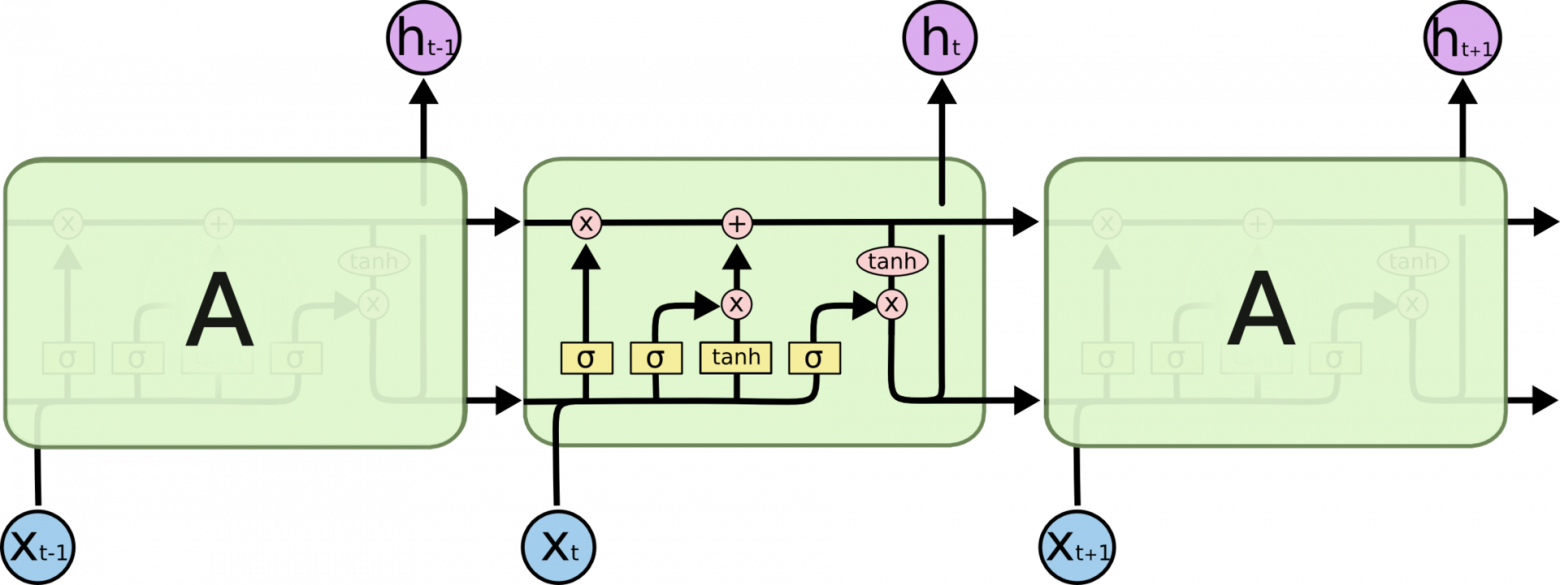

рассчитываем состояние входного гейта (input gate)
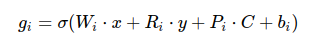

рассчитываем состояние гейта памяти (forget gate)  
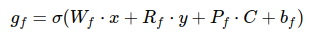

рассчитываем изменение памяти  
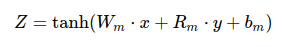

обновляем состояние памяти сети (memory cell) 
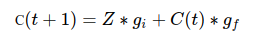

рассчитываем состояние выходного гейта (output gate) 
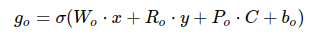

рассчитываем выход сети 
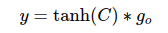

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class ModelRNN(nn.Module):
    
    def __init__(self, vocabulary, embedding_len=128, hidden_dim=512,):
        super().__init__()
        self._vocabulary = vocabulary
        self._embeddings = nn.Embedding( len(vocabulary), embedding_len )
        self._lstm = nn.LSTM( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True, num_layers=1, ) 
        self._linear = nn.Linear( hidden_dim, len(vocabulary) )

    def forward(self,x):
        o = self._embeddings(x)
        o,_ = self._lstm(o) # обрабатываем входную последовательность
        o = o[:,-1]
        o = self._linear(o) # считаем выход сети
        # o = F.softmax(o,dim=-1)
        o = F.log_softmax(o,dim=-1)
        return o
    
    def predict(self,x):
        return torch.argmax( self.forward(x), dim=-1 ) #, keepdims=True)
    
    @property
    def vocabulary(self): return self._vocabulary

In [18]:
# x,t = ds[:2]
# display(x.shape,t.shape)
# display(len(ds.vocabulary))

# model = ModelRNN(vocabulary=ds.vocabulary)

# o = model.forward(x)
# display( o.shape )

# o = model.predict(x)
# display( o.shape )

# обучаем модель

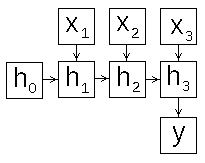

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

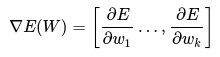


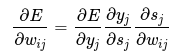

процедура обратного распространения ошибки

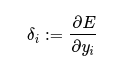

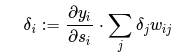

In [19]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [20]:
model = ModelRNN(vocabulary=ds.vocabulary,).to(device)

In [21]:
# ф-ция потери
# criterion =  nn.BCELoss()
criterion = nn.NLLLoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

In [22]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [23]:
loss_history = [] # значения ф-ции потери

In [24]:
%%time

n_epoch = 32 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds, batch_size=len(ds)//5, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    if loss_history[-1]<1e-2: break

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 468 ms, sys: 34.2 ms, total: 502 ms
Wall time: 507 ms


Text(0.5, 1.0, 'min loss: 0.00912')

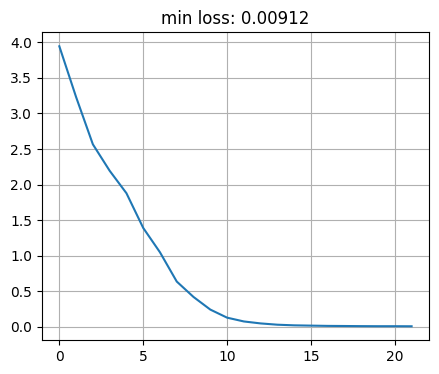

In [25]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [26]:
from sklearn.metrics import accuracy_score


for x,t in DataLoader(ds,len(ds)): break

with torch.set_grad_enabled(False): # генерируем следующий токен
    p = model.predict(x.to(device)).cpu().numpy() #.item()
        
display( accuracy_score(y_true=t.numpy(), y_pred=p ) )

1.000

In [27]:
import pandas as pd

In [28]:
def decode(x,vocabulary):
    v = { n:w for w,n in  vocabulary.items() }
    return [
        ''.join([ v[c] for c in s ])
        for s in x
    ]

In [29]:
import pandas as pd

# декодируем слова
df = pd.DataFrame({
         'sequence': decode(x.numpy(),ds.vocabulary),
           'target': decode(t.numpy().reshape(-1,1),ds.vocabulary),
         'predicted': decode(p.reshape(-1,1),ds.vocabulary)
    })

display(df)

,sequence,target,predicted
0,", всё ему удавалось, он",б,б
1,"ось, он был в моде. В об",щ,щ
2,де. В обществе в губернс,к,к
3,губернском если кто раз,,
4,"кто раз появился, то уж",,
...,...,...,...
58,"его, что он с нею не та",к,к
59,ею не так откровенен; Ни,к,к
60,енен; Николай Всеволодов,и,и
61,еволодович улыбался и пр,о,о
